# Loading and saving the dataset

In [1]:
from datasets import load_dataset

# Load dataset from huggingface
dataset = load_dataset("Micol/musical-instruments-sound-dataset")

In [2]:
# Optional -> save to disk to prevent re-download
# dataset.save_to_disk("data/")

---------
# Dataset preprocessing

In [3]:
import torch
from torchaudio.transforms import MelSpectrogram, Resample
from torch.utils.data import DataLoader, Dataset as TorchDataset

In [4]:
# Define a custom PyTorch Dataset for pre-processing
class AudioDataset(TorchDataset):
    def __init__(self, dataset, target_sr=16000, fixed_duration=10): # Mean audio duration is ~ 18s
        """
        Custom PyTorch Dataset for audio classification.
        
        Args:
            dataset: Hugging Face dataset containing 'audio' and 'label' columns.
            target_sr: Target sampling rate to resample all audio.
            fixed_duration: Fixed duration for all audio clips (in seconds).
        """
        self.dataset = dataset
        self.target_sr = target_sr
        self.num_samples = target_sr * fixed_duration

        # Mel Spectrogram transform
        self.mel_transform = MelSpectrogram(
            sample_rate=target_sr, 
            n_fft=1024, 
            hop_length=512, 
            n_mels=64
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load audio and label
        audio_array = self.dataset[idx]['audio']['array']
        sr = self.dataset[idx]['audio']['sampling_rate']
        label = self.dataset[idx]['label']
        
        # Convert to PyTorch tensor
        audio_tensor = torch.tensor(audio_array, dtype=torch.float32)

        # Resample if needed
        if sr != self.target_sr:
            resample_transform = Resample(orig_freq=sr, new_freq=self.target_sr)
            audio_tensor = resample_transform(audio_tensor)

        # Pad or truncate audio to fixed length
        if audio_tensor.shape[0] > self.num_samples:
            audio_tensor = audio_tensor[:self.num_samples]  # Truncate
        else:
            padding = self.num_samples - audio_tensor.shape[0]
            audio_tensor = torch.nn.functional.pad(audio_tensor, (0, padding))  # Pad with zeros

        # Convert to Mel Spectrogram
        mel_spectrogram = self.mel_transform(audio_tensor)

        return mel_spectrogram, label

In [5]:
# Split dataset into train and test sets
train_dataset = AudioDataset(dataset['train'])
validation_dataset = AudioDataset(dataset['validation'])
test_dataset = AudioDataset(dataset['test'])

In [6]:
# Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

----
# Model implementation

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class AudioClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifier, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # Output: [16, 64, 313]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1) # Output: [32, 32, 157]
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # Output: [64, 16, 79]

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 79, 256)  # Flattened size
        self.fc2 = nn.Linear(256, num_classes)   # Output layer

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Input shape: [batch_size, 1, 64, 313]
        x = F.relu(self.conv1(x))  # [batch_size, 16, 64, 313]
        x = F.relu(self.conv2(x))  # [batch_size, 32, 32, 157]
        x = F.relu(self.conv3(x))  # [batch_size, 64, 16, 79]

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [9]:
# Number of classes based on dataset
num_classes = len(dataset['train'].features['label'].names)

# Instantiate the model
model = AudioClassifier(num_classes=num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

In [10]:
from tqdm import tqdm

# train loop
def train(model, train_loader, validation_loader, criterion, optimizer, device, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        # Training phase
        for mel_spectrograms, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            mel_spectrograms, labels = mel_spectrograms.unsqueeze(1).to(device), labels.to(device)

            # Forward pass
            outputs = model(mel_spectrograms)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for mel_spectrograms, labels in validation_loader:
                mel_spectrograms, labels = mel_spectrograms.unsqueeze(1).to(device), labels.to(device)

                outputs = model(mel_spectrograms)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(validation_loader)
        accuracy = correct / total

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Accuracy = {accuracy:.4f}")

In [11]:
train(model, train_loader, validation_loader, criterion, optimizer, device, epochs=50)

Epoch 1/50: 100%|██████████| 66/66 [01:05<00:00,  1.02it/s]


Epoch 1: Train Loss = 42.5746, Val Loss = 1.2771, Val Accuracy = 0.4354


Epoch 2/50: 100%|██████████| 66/66 [00:56<00:00,  1.16it/s]


Epoch 2: Train Loss = 1.1965, Val Loss = 1.1652, Val Accuracy = 0.4848


Epoch 3/50: 100%|██████████| 66/66 [00:56<00:00,  1.17it/s]


Epoch 3: Train Loss = 1.1720, Val Loss = 1.3691, Val Accuracy = 0.4981


Epoch 4/50: 100%|██████████| 66/66 [00:56<00:00,  1.17it/s]


Epoch 4: Train Loss = 1.0316, Val Loss = 1.2891, Val Accuracy = 0.5798


Epoch 5/50: 100%|██████████| 66/66 [00:55<00:00,  1.18it/s]


Epoch 5: Train Loss = 0.9757, Val Loss = 1.4455, Val Accuracy = 0.5760


Epoch 6/50: 100%|██████████| 66/66 [00:55<00:00,  1.18it/s]


Epoch 6: Train Loss = 0.9245, Val Loss = 1.3809, Val Accuracy = 0.5741


Epoch 7/50: 100%|██████████| 66/66 [00:54<00:00,  1.20it/s]


Epoch 7: Train Loss = 0.7316, Val Loss = 0.8902, Val Accuracy = 0.6217


Epoch 8/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 8: Train Loss = 0.6200, Val Loss = 0.9209, Val Accuracy = 0.6122


Epoch 9/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 9: Train Loss = 0.6084, Val Loss = 0.6695, Val Accuracy = 0.6407


Epoch 10/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 10: Train Loss = 0.4945, Val Loss = 0.6430, Val Accuracy = 0.6350


Epoch 11/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 11: Train Loss = 0.4375, Val Loss = 0.6860, Val Accuracy = 0.5989


Epoch 12/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 12: Train Loss = 0.4148, Val Loss = 0.7725, Val Accuracy = 0.5703


Epoch 13/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 13: Train Loss = 0.4070, Val Loss = 0.7516, Val Accuracy = 0.6008


Epoch 14/50: 100%|██████████| 66/66 [00:54<00:00,  1.22it/s]


Epoch 14: Train Loss = 0.3999, Val Loss = 0.6808, Val Accuracy = 0.6141


Epoch 15/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 15: Train Loss = 0.3958, Val Loss = 0.7702, Val Accuracy = 0.5951


Epoch 16/50: 100%|██████████| 66/66 [00:53<00:00,  1.22it/s]


Epoch 16: Train Loss = 0.3887, Val Loss = 0.7363, Val Accuracy = 0.6198


Epoch 17/50: 100%|██████████| 66/66 [00:53<00:00,  1.22it/s]


Epoch 17: Train Loss = 0.3873, Val Loss = 0.8642, Val Accuracy = 0.5380


Epoch 18/50: 100%|██████████| 66/66 [00:54<00:00,  1.22it/s]


Epoch 18: Train Loss = 0.3817, Val Loss = 0.7963, Val Accuracy = 0.5837


Epoch 19/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 19: Train Loss = 0.3777, Val Loss = 0.7489, Val Accuracy = 0.6065


Epoch 20/50: 100%|██████████| 66/66 [00:52<00:00,  1.25it/s]


Epoch 20: Train Loss = 0.3762, Val Loss = 0.8239, Val Accuracy = 0.5779


Epoch 21/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 21: Train Loss = 0.3732, Val Loss = 0.9081, Val Accuracy = 0.5589


Epoch 22/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 22: Train Loss = 0.3750, Val Loss = 0.8284, Val Accuracy = 0.5323


Epoch 23/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 23: Train Loss = 0.3699, Val Loss = 0.8135, Val Accuracy = 0.5589


Epoch 24/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 24: Train Loss = 0.3704, Val Loss = 0.8590, Val Accuracy = 0.5722


Epoch 25/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 25: Train Loss = 0.3728, Val Loss = 0.8497, Val Accuracy = 0.5570


Epoch 26/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 26: Train Loss = 0.3653, Val Loss = 0.8665, Val Accuracy = 0.5646


Epoch 27/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 27: Train Loss = 0.3674, Val Loss = 0.9198, Val Accuracy = 0.5133


Epoch 28/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 28: Train Loss = 0.3656, Val Loss = 0.9437, Val Accuracy = 0.5209


Epoch 29/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 29: Train Loss = 0.3643, Val Loss = 1.1614, Val Accuracy = 0.5323


Epoch 30/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 30: Train Loss = 0.3673, Val Loss = 0.9049, Val Accuracy = 0.5152


Epoch 31/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 31: Train Loss = 0.3638, Val Loss = 1.0372, Val Accuracy = 0.5304


Epoch 32/50: 100%|██████████| 66/66 [00:53<00:00,  1.22it/s]


Epoch 32: Train Loss = 0.3639, Val Loss = 0.9242, Val Accuracy = 0.5152


Epoch 33/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 33: Train Loss = 0.3636, Val Loss = 0.9308, Val Accuracy = 0.5209


Epoch 34/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 34: Train Loss = 0.3652, Val Loss = 0.8629, Val Accuracy = 0.5095


Epoch 35/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 35: Train Loss = 0.3606, Val Loss = 0.9694, Val Accuracy = 0.5152


Epoch 36/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 36: Train Loss = 0.3666, Val Loss = 0.8317, Val Accuracy = 0.5266


Epoch 37/50: 100%|██████████| 66/66 [00:52<00:00,  1.25it/s]


Epoch 37: Train Loss = 0.3875, Val Loss = 0.8849, Val Accuracy = 0.5456


Epoch 38/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 38: Train Loss = 0.7937, Val Loss = 0.8157, Val Accuracy = 0.6179


Epoch 39/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 39: Train Loss = 0.6477, Val Loss = 0.7077, Val Accuracy = 0.6160


Epoch 40/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 40: Train Loss = 0.5587, Val Loss = 0.7138, Val Accuracy = 0.6008


Epoch 41/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 41: Train Loss = 0.4220, Val Loss = 0.7230, Val Accuracy = 0.5875


Epoch 42/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 42: Train Loss = 0.3886, Val Loss = 0.7993, Val Accuracy = 0.5418


Epoch 43/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 43: Train Loss = 0.4351, Val Loss = 0.8421, Val Accuracy = 0.6046


Epoch 44/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 44: Train Loss = 0.3944, Val Loss = 0.7900, Val Accuracy = 0.5418


Epoch 45/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 45: Train Loss = 0.3707, Val Loss = 0.8813, Val Accuracy = 0.5285


Epoch 46/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 46: Train Loss = 0.3757, Val Loss = 0.7877, Val Accuracy = 0.5171


Epoch 47/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 47: Train Loss = 0.3690, Val Loss = 0.8784, Val Accuracy = 0.5494


Epoch 48/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 48: Train Loss = 0.3655, Val Loss = 1.0475, Val Accuracy = 0.5247


Epoch 49/50: 100%|██████████| 66/66 [00:52<00:00,  1.25it/s]


Epoch 49: Train Loss = 0.3653, Val Loss = 0.9117, Val Accuracy = 0.5304


Epoch 50/50: 100%|██████████| 66/66 [00:52<00:00,  1.25it/s]


Epoch 50: Train Loss = 0.3628, Val Loss = 0.9799, Val Accuracy = 0.5513


-----
# Evaluate

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Test Accuracy: 0.5250
Confusion Matrix:


<Figure size 1000x700 with 0 Axes>

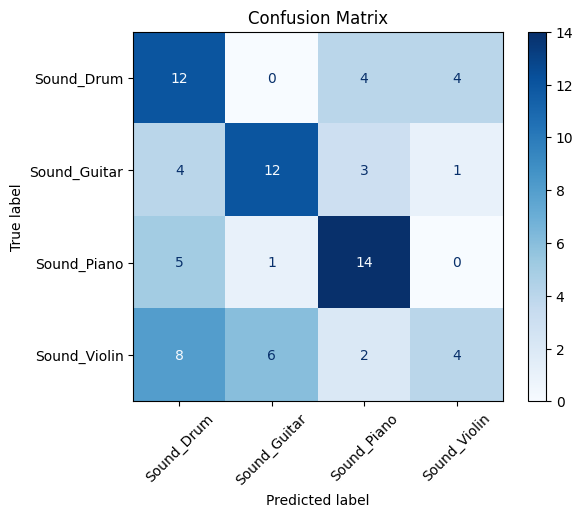

In [13]:
def evaluate(model, test_loader, device, class_names):
    model.eval()
    correct = 0
    total = 0
    
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for mel_spectrograms, labels in test_loader:
            mel_spectrograms, labels = mel_spectrograms.unsqueeze(1).to(device), labels.to(device)

            outputs = model(mel_spectrograms)
            _, predicted = torch.max(outputs, 1)

            # Track overall accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for the confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    print("Confusion Matrix:")
    plt.figure(figsize=(10, 7))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.show()

# Evaluate on test set
evaluate(model, test_loader, device, dataset['train'].features['label'].names)

In [14]:
torch.save(model, 'first_idea.pth')